
0: 384x640 1 car, 50.8ms
Speed: 2.3ms preprocess, 50.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 49.0ms
Speed: 2.2ms preprocess, 49.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 47.3ms
Speed: 2.3ms preprocess, 47.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 46.6ms
Speed: 2.1ms preprocess, 46.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 cars, 43.6ms
Speed: 2.2ms preprocess, 43.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 plate, 45.3ms
Speed: 2.2ms preprocess, 45.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 plate, 47.9ms
Speed: 2.1ms preprocess, 47.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 68.3ms
Speed: 3.4ms preprocess, 68.3ms inference, 0.8ms postprocess per image at shap

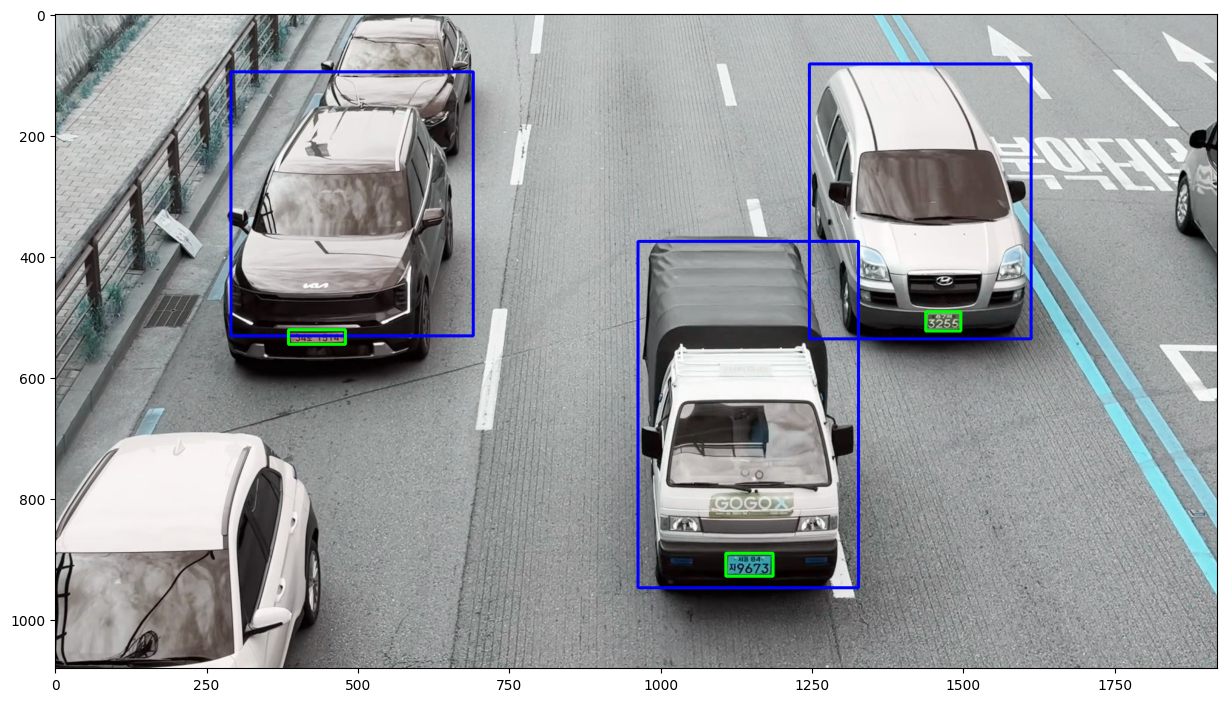

In [26]:
import cv2
from ultralytics import YOLO
import os
from typing import List, Dict
def detect_objects(results, x_offset=0, y_offset=0, scale_x=1, scale_y=1):
    """ Bounding Box 좌표를 조정하고 크기 변경 """
    frame_result = {'xywh': [], 'confidence': []}
    
    for result in results[0].boxes:
        if result.conf[0].item():

            xywh = result.xywh[0].tolist()
            conf = result.conf[0].item()
        
            xywh[0] += x_offset
            xywh[1] += y_offset
            xywh[2] *= scale_x
            xywh[3] *= scale_y
        
            frame_result['xywh'].append(xywh)
            frame_result['confidence'].append(conf)
    
    return frame_result

def process_frame(model,frame):
    H, W = frame.shape[:2]
    # 4분할 처리
    quarters = [
        (frame[0:H//2, 0:W//2], 0, 0),
        (frame[0:H//2, W//2:W], W//2, 0),
        (frame[H//2:H, 0:W//2], 0, H//2),
        (frame[H//2:H, W//2:W], W//2, H//2)
    ]
    
    combined_results = {'xywh': [], 'confidence': []}
    for img, x_offset, y_offset in quarters:
        quarter_results = model(img,iou=0.1)
        detected = detect_objects(quarter_results, x_offset, y_offset)
        combined_results['xywh'].extend(detected['xywh'])
        combined_results['confidence'].extend(detected['confidence'])
    original_results = model(frame,iou=0.1)
    detected = detect_objects(original_results, x_offset=0, y_offset=0)
    combined_results['xywh'].extend(detected['xywh'])
    combined_results['confidence'].extend(detected['confidence'])
    

    return combined_results

def draw_bbox(frame,frame_result,color,thickness):

    
    for i in range(len(frame_result)):
        x_1,y_1,x_2,y_2 = map(int,frame_result[i])
        
        
        frame = cv2.rectangle(frame,(x_1,y_1),(x_2,y_2),color=color,thickness=thickness)


    return frame

def calculate_area(bbox):
    """ 주어진 bbox의 면적을 계산 """
    x1, y1, x2, y2 = bbox
    return (x2 - x1) * (y2 - y1)
def calculate_iou(xyxy1, xyxy2):
    """
    두 bounding box의 IOU 를 계산
    
    Args:
        xyxy1 (list): 첫 번째 bounding box [x1, y1, x2, y2]
        xyxy2 (list): 두 번째 bounding box [x1, y1, x2, y2]
    
    Returns:
        float: IOU ex)0.387
    """
   
    x1_inter = max(xyxy1[0], xyxy2[0])
    y1_inter = max(xyxy1[1], xyxy2[1])
    x2_inter = min(xyxy1[2], xyxy2[2])
    y2_inter = min(xyxy1[3], xyxy2[3])

    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

    area1 = (xyxy1[2] - xyxy1[0]) * (xyxy1[3] - xyxy1[1])
    area2 = (xyxy2[2] - xyxy2[0]) * (xyxy2[3] - xyxy2[1])

    union_area = area1 + area2 - inter_area
    iou = inter_area / union_area if union_area > 0 else 0
    
    return iou
def NMS_only_xyxy_big(bbox_list, iou_threshold=0.2):
    '''
    가장 넓은 bbox를 우선으로 하여 NMS를 적용하는 함수

    Args:
        bbox_list (list) : [[x1,y1,x2,y2],[x3,y3,x4,y4],,,]로 저장된 bbox 리스트
        iou_threshold (float): IoU 임계값 (기본값 0.2)

    Returns:
        result_bbox : NMS를 거쳐 선택된 bbox 리스트
    '''
    if len(bbox_list) == 0:
        return []

    # bbox를 면적 기준으로 내림차순 정렬
    bbox_list = sorted(bbox_list, key=calculate_area, reverse=True)
    
    selected_bboxes = []
    
    while bbox_list:
        # 가장 넓은 bbox를 선택
        base_bbox = bbox_list.pop(0)
        selected_bboxes.append(base_bbox)
        
        # 남은 bbox 중 IoU가 threshold 이상인 bbox 제거
        bbox_list = [bbox for bbox in bbox_list if calculate_iou(base_bbox, bbox) <= iou_threshold]

    return selected_bboxes
def NMS_only_xyxy_small(bbox_list, iou_threshold=0.2):
    '''
    가장 작은 bbox를 우선으로 하여 NMS를 적용하는 함수

    Args:
        bbox_list (list) : [[x1,y1,x2,y2],[x3,y3,x4,y4],,,]로 저장된 bbox 리스트
        iou_threshold (float): IoU 임계값 (기본값 0.2)

    Returns:
        result_bbox : NMS를 거쳐 선택된 bbox 리스트
    '''
    if len(bbox_list) == 0:
        return []

    # bbox를 면적 기준으로 내림차순 정렬
    bbox_list = sorted(bbox_list, key=calculate_area, reverse=False)
    
    selected_bboxes = []
    
    while bbox_list:
        # 가장 넓은 bbox를 선택
        base_bbox = bbox_list.pop(0)
        selected_bboxes.append(base_bbox)
        
        # 남은 bbox 중 IoU가 threshold 이상인 bbox 제거
        bbox_list = [bbox for bbox in bbox_list if calculate_iou(base_bbox, bbox) <= iou_threshold]

    return selected_bboxes
def process_video(video_path: str) -> List[Dict[str, List[float]]]:
    
    """
    주어진 영상 파일을 프레임별로 처리하고, YOLO 모델을 사용하여 객체를 탐지
    
    Args:
        video_path (str): 처리할 영상 파일 경로입니다. 예) '/path/to/video.mp4'

    Returns:
        List[Dict[str, List[float]]]: 각 프레임마다 탐지된 객체의 정보를 담은 딕셔너리의 리스트를 반환.
                                      예) [{'xywh': [x_center, y_center, width, height], 'confidence': [0.99]}, ...]
    """
   
    
    
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    car_detection_results = []  
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # 영상 끝까지 읽었으면 종료
        frame_idx += 1
        car_frame_result = process_frame(model1,frame) #현재
        plate_frame_result = process_frame(model2,frame) #현재
        car_frame_result = NMS_only_xyxy_small(car_frame_result['xywh'])
        plate_frame_result = NMS_only_xyxy_big(plate_frame_result['xywh'])
        car_detection_results.append(car_frame_result) #이전+현재
        

        frame = draw_bbox(frame,car_frame_result,(0,0,255),thickness=3)    
        frame = draw_bbox(frame,plate_frame_result,(0,255,0),thickness=3)
        save_path = os.path.join(save_dir, f"frame_{frame_idx}.jpg")
        cv2.imwrite(save_path, frame) 
        
    cap.release()
    return car_detection_results 


def xywh_to_xyxy(xywh):
    for i in range(len(xywh)) : 
        x_c,y_c,w,h = map(int,xywh[i])
        x_1 = x_c-w//2
        y_1 = y_c-h//2
        x_2 = x_c+w//2
        y_2 = y_c+h//2
        xywh[i]=[x_1,y_1,x_2,y_2]
    return xywh    
def xyxy_to_xywh(xyxy):
    for i in range(len(xyxy)) : 
        x_1,y_1,x_2,y_2 = map(int,xyxy[i])
        w = x_2-x_1
        h = y_2-y_1
        x_c = x_1+w//2
        y_c = y_1+h//2
        xyxy[i]=[x_c,y_c,w,h]
    return xyxy   
import matplotlib.pyplot as plt
if __name__ == "__main__":
    model1 = YOLO('/mnt/hdd_6tb/bill0914/YOLOv11n_ car.pt')
    model2 = YOLO("/mnt/hdd_6tb/bill0914/processed_quarter/runs/detect/train2-4분할+resize+DA2/weights/best.pt")
    save_dir = '/mnt/hdd_6tb/bill0914/tracking/tracking_car/result_frame'
    img = cv2.imread("/mnt/hdd_6tb/bill0914/tracking/tracking_car/original_frame/frame_50.jpg")
    car_frame_result = process_frame(model1,img)
    car_frame_result_xyxy = xywh_to_xyxy(car_frame_result['xywh'])
    plate_frame_result = process_frame(model2,img)
    plate_frame_result_xyxy = xywh_to_xyxy(plate_frame_result['xywh'])
    car_frame_result = NMS_only_xyxy_big(car_frame_result_xyxy)
    plate_frame_result = NMS_only_xyxy_big(plate_frame_result_xyxy)
    print(car_frame_result)
    frame = draw_bbox(img,car_frame_result,(0,0,255),thickness=3)
    frame = draw_bbox(img,plate_frame_result,(0,255,0),thickness=3)
    plt.figure(figsize=(15,15))
    plt.imshow(frame)


    
    

In [ ]:
_